Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

300


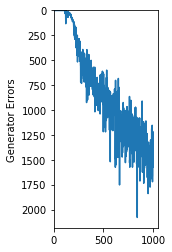

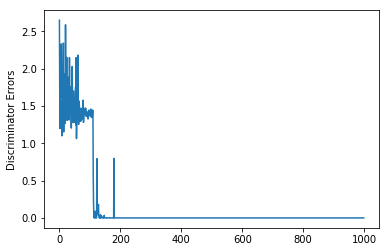

In [4]:
%matplotlib inline
from IPython import display
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import collections
import hashlib
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import numpy as np
import torch
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import tensor_shape
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat


TRAIN_DATA_FOLDER = './tf_data/train_photos/'
TEST_DATA_FOLDER = './tf_data/test_photos/'
IMAGE_PIXELS = 28*28*3
NOISE_SIZE = 10
BATCH_SIZE = 10


def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

def xavier_init(size):
    in_dim = size[0] if len(size) == 1 else size[1]
    stddev = 1. / np.sqrt(float(in_dim))
    return tf.random_uniform(shape=size, minval=-stddev, maxval=stddev)

def images_to_vectors(images):
    return images.reshape(images.shape[0], 2352)


def vectors_to_images(vectors):
    return vectors.reshape(vectors.shape[0], 28, 28, 3)


def get_data(folder):
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    return datasets.ImageFolder(folder, transform=compose)

def separate_data(data_loader):
  negative_data = torch.FloatTensor([])
  positive_data = torch.FloatTensor([])
  
  negative_counter = 0
  positive_counter = 0
  for n_batch, (batch, label) in enumerate(data_loader):
    if(label[0] == 0):
        negative_data = torch.cat((negative_data, batch))
        negative_counter +=1
    else:
        positive_data = torch.cat((positive_data, batch))
        positive_counter +=1

  return negative_data.resize_((negative_counter, 10, 3, 28, 28)), positive_data.resize_(positive_counter, 10, 3, 28, 28)


# Load train and test data
train_data = get_data(TRAIN_DATA_FOLDER)
test_data = get_data(TEST_DATA_FOLDER)

# Create loader with data, so that we can iterate over it
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Separate the negative data from the positive ones
train_negatives, train_positives = separate_data(train_data_loader)
test_negatives, test_positives = separate_data(test_data_loader)

# print shape of test negatives and test positives
print(test_negatives.shape)
print(test_positives.shape)

# Num batches
num_batches = len(train_data_loader)


## Discriminator

# Input
X = tf.placeholder(tf.float32, shape=(None, IMAGE_PIXELS))

# Layer 1 Variables
D_W1 = tf.Variable(xavier_init([2352, 1024]))
D_B1 = tf.Variable(xavier_init([1024]))

# Layer 2 Variables
D_W2 = tf.Variable(xavier_init([1024, 512]))
D_B2 = tf.Variable(xavier_init([512]))

# Layer 3 Variables
D_W3 = tf.Variable(xavier_init([512, 256]))
D_B3 = tf.Variable(xavier_init([256]))

# Out Layer Variables
D_W4 = tf.Variable(xavier_init([256, 1]))
D_B4 = tf.Variable(xavier_init([1]))

# Store Variables in list
D_var_list = [D_W1, D_B1, D_W2, D_B2, D_W3, D_B3, D_W4, D_B4]


## setting up a Generator network

# Input
Z = tf.placeholder(tf.float32, shape=(None, IMAGE_PIXELS))

# Layer 1 Variables
G_W1 = tf.Variable(xavier_init([2352, 256]))
G_B1 = tf.Variable(xavier_init([256]))

# Layer 2 Variables
G_W2 = tf.Variable(xavier_init([256, 512]))
G_B2 = tf.Variable(xavier_init([512]))

# Layer 3 Variables
G_W3 = tf.Variable(xavier_init([512, 1024]))
G_B3 = tf.Variable(xavier_init([1024]))

# Out Layer Variables
G_W4 = tf.Variable(xavier_init([1024, 2352]))
G_B4 = tf.Variable(xavier_init([2352]))

# Store Variables in list
G_var_list = [G_W1, G_B1, G_W2, G_B2, G_W3, G_B3, G_W4, G_B4]

def discriminator(x):
    l1 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(x,   D_W1) + D_B1, .2), .3)
    l2 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(l1,  D_W2) + D_B2, .2), .3)
    l3 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(l2,  D_W3) + D_B3, .2), .3)
    out = tf.matmul(l3, D_W4) + D_B4
    return out

def generator(z):
    l1 = tf.nn.leaky_relu(tf.matmul(z,  G_W1) + G_B1, .2)
    l2 = tf.nn.leaky_relu(tf.matmul(l1, G_W2) + G_B2, .2)
    l3 = tf.nn.leaky_relu(tf.matmul(l2, G_W3) + G_B3, .2)
    out = tf.nn.tanh(tf.matmul(l3, G_W4) + G_B4)
    return out

G_sample = generator(Z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

# Losses
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

# Optimizers
D_opt = tf.train.AdamOptimizer(2e-4).minimize(D_loss, var_list=D_var_list)
G_opt = tf.train.AdamOptimizer(2e-4).minimize(G_loss, var_list=G_var_list)

# Variable initialization
num_epochs = 1000

# Start interactive session
session = tf.InteractiveSession()

# Init Variables
tf.global_variables_initializer().run()

# Init Logger
# Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047
tf.logging.set_verbosity(tf.logging.INFO)

g_errors = []
d_errors = []

#Training
# Iterate through epochs
#Training
# Iterate through epochs
for epoch in range(num_epochs):
    print(epoch)
    for n_batch, batch in enumerate(train_negatives):

        # 1. Train Discriminator
        if(n_batch == train_positives.shape[0]):
            break
        else:
            X_batch = images_to_vectors(train_positives[n_batch].permute(0, 2, 3, 1).numpy())
        
    
            
        Z_batch = images_to_vectors(batch.permute(0, 2, 3, 1).numpy())
        feed_dict = {X: X_batch, Z: Z_batch}
        _, d_error, d_pred_real, d_pred_fake = session.run(
            [D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict
        )

        # 2. Train Generator
        feed_dict = {Z: Z_batch}
        _, g_error = session.run(
            [G_opt, G_loss], feed_dict=feed_dict
        )

        if n_batch % 100 == 0:
            display.clear_output(True)
            print(n_batch)
            Z_batch_test = images_to_vectors(test_negatives[round(n_batch / 100)].permute(0, 2, 3, 1).numpy())
            # Generate images from test noise
            test_images = session.run(
                G_sample, feed_dict={Z: Z_batch_test}
            )
            test_images = vectors_to_images(test_images)
            # Log Images
            for i in range(10):
                imgplot = plt.imshow(test_images[i])


#             # Log Status
#             tf.logging.info(
#                 epoch, num_epochs, n_batch, num_batches,
#                 d_error, g_error, d_pred_real, d_pred_fake
#             )
            
    g_errors.append(g_error)
    d_errors.append(d_error)
    
# Print the graph of the error progression for the generator and discriminator
plt.plot(g_errors)
plt.ylabel('Generator Errors')
plt.show()

plt.plot(d_errors)
plt.ylabel('Discriminator Errors')
plt.show()


In [2]:
# Print the graph of the error progression for the generator and discriminator
import matplotlib.pyplot as plt
fig_size = [500, 500]
plt.plot(g_errors)
plt.ylabel('Generator Errors')
plt.rcParams["figure.figsize"] = fig_size
plt.show()

plt.plot(d_errors)
plt.ylabel('Discriminator Errors')
plt.rcParams["figure.figsize"] = fig_size
plt.show()


NameError: name 'g_errors' is not defined